In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import time

now = time.time

sns.set(style='white', context='notebook', palette='deep')


# loading the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")



#the response 
Y_train = train["label"]


#Get rid of responses on data
X_train = train.drop(labels = ["label"], axis = 1)

#free up some space
del train


#Examine the data a bit
g = sns.countplot(Y_train)
Y_train.value_counts()



# Normalize data
X_train = X_train/255.0
test = test/255.0


#Reshape the data

X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)



# Encoded to 1 hot vectors (placeholders for what the values are. EG, 6 = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
Y_train = to_categorical(Y_train, num_classes = 10)


# Lets set the seed and get down to buissness 
random_seed = 69

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)



# actualy model creation

model = Sequential()


# every 5x5 scan gets analyzed it with 32 different layer patterns. Since the padding is 'same'
# the dimensions of the new matrix are the same as the old.
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))

# This proccess is repeated on the new;y formed matrix
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation ='relu'))


# With pooling, the dimensionality is reduced by half.
model.add(MaxPool2D(pool_size = (2, 2)))


#lets not overfit, so we drop the values in the pooled matrix by a ratio of 1/4
model.add(Dropout(0.25))
model.summary()


# The same proccess except now every one of the those 32 laters for each 5x5 section are scanned
# over with 64 filters done by a 3x3 scanner
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation ='relu'))

# Then done again for the new matrix
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation ='relu'))

# pooled
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# dropped to rpevent overfitting 
model.add(Dropout(0.25))





# This new long matrix is flattened
model.add(Flatten())

# Then set up as new nodes connected to 256 more nodes of another layer
model.add(Dense(512, activation = "relu"))

#Dropped MORE to prevent overfitting
model.add(Dropout(0.5))

# Given final layer to final preds, given a prob distribution
model.add(Dense(10, activation = "softmax"))


model.summary()

optimizer = RMSprop(lr= 0.001, rho = 0.9, epsilon = 0.00000001, decay = 0)

model.compile(optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, 
                                            verbose = 1, factor = 0.5, min_lr = .00001)
# make higher for better results
epochs = 30
batch_size = 86

# Re-do without augmentaion to get different results

'''history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val), verbose = 1)
'''


# Below is all of the data augmentation and stuff. (rotations, zooms and stretches and centers)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



datagen.fit(X_train)

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])



# cool plots and shit Meansuring the progress over epochs 

#default .984
#no augment, 1 epoch, .9248
history

#runtime = time.time - now




/Users/travisbarton/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
Total params: 26,464
Trainable params: 26,464
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'builtin_function_or_method'

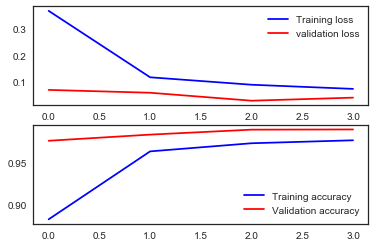

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



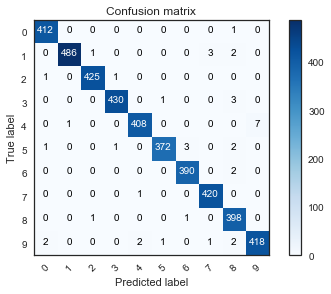

In [2]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    # "thats tight..." -Kris. it fixes layouts easily    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))







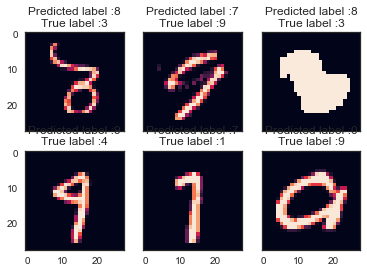

In [3]:

# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

# wrongly predicted values
Y_pred_classes_errors = Y_pred_classes[errors]

# Probs of wrongly predicted values
Y_pred_errors = Y_pred[errors]

# True classifications
Y_true_errors = Y_true[errors]

# Actual images of wrong values
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


In [4]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [6]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn.csv",index=False)